In [1]:
from torchvision import datasets, transforms
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

In [2]:
batch_size = 64
test_batch_size = 1000

In [3]:
class ConvNet(nn.Module):
    def __init__(self, input_size=(28, 28), output_size=10, num_layers=5, growth=2):
        super(ConvNet, self).__init__()
        self.num_layers = num_layers
        layers, channels, initial_growth = [], 1, 16
        for i in range(num_layers):
            next_channels = int(channels * growth * initial_growth)
            layers.append(nn.Conv2d(channels, next_channels, kernel_size=3, bias=False))
            init.kaiming_uniform(layers[-1].weight.data)
            layers.append(nn.BatchNorm2d(next_channels))
            layers[-1].weight.data.fill_(1)
            layers[-1].bias.data.fill_(0)
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            channels, initial_growth = next_channels, 1
        self.filter = nn.Sequential(*layers)
        self.classifier = nn.Linear(in_features=channels, out_features=10, bias=False)
        init.kaiming_uniform(self.classifier.weight.data)

    def forward(self, batch):
        return F.log_softmax(self.classifier(F.adaptive_avg_pool2d(self.filter(batch), 1).squeeze()))

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=test_batch_size, shuffle=True)

In [5]:
def find_lr(model, train_dl, epochs=1, start=1e-4, end=8.0, beta=0.98):
    optimizer = optim.SGD(model.parameters(), lr=start, momentum=0.99)
    avg_loss, best_loss = 0, float('inf')
    step = (end / start) ** (1/(len(train_dl) * epochs - 1))
    i, lr = 1, start
    lr_losses = []
    for _ in range(epochs):
        for data, labels in train_dl:
            input, target = Variable(data), Variable(labels)
            model.zero_grad()
            optimizer.zero_grad()
            output = model(input)
            loss = F.nll_loss(output, target)
            avg_loss = beta * avg_loss + (1-beta) * loss.data.item()
            smoothed_loss = avg_loss / (1 - beta ** i)
            lr_losses.append((lr, smoothed_loss))
            if smoothed_loss > 4 * best_loss:
                return lr_losses
            elif smoothed_loss < best_loss:
                best_loss = smoothed_loss
            loss.backward()
            optimizer.step()
            lr *= step
            optimizer.param_groups[0]['lr'] = lr
            i += 1
    return lr_losses

In [6]:
torch.manual_seed(42)
net = ConvNet(num_layers=2)
net.train()
lr_losses = find_lr(net, train_loader, epochs=1)

/home/kcy1019/.pyenv/versions/deep/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  if __name__ == '__main__':
/home/kcy1019/.pyenv/versions/deep/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/kcy1019/.pyenv/versions/deep/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


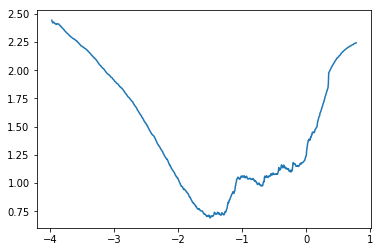

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
xs, ys = ([math.log10(p[0]) for p in lr_losses[5:-10]], [p[1] for p in lr_losses[5:-10]])
plt.plot(xs, ys)

In [15]:
def train(model, train_dl, epochs=10, lr=0.1):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99)
    avg_losses, num_examples = [], len(train_dl)
    for _ in range(epochs):
        avg_loss = 0
        for data, labels in train_dl:
            input, target = Variable(data), Variable(labels)
            model.zero_grad()
            optimizer.zero_grad()
            output = model(input)
            loss = F.nll_loss(output, target)
            avg_loss += loss / num_examples
            loss.backward()
            optimizer.step()
        print(f'Epoch [{_:2d}/{epochs:2d}]: avg loss {avg_loss:.2f}')
        avg_losses.append(avg_loss)
    return avg_losses

In [ ]:
torch.manual_seed(42)
net = ConvNet(num_layers=2)
train(net, train_loader, ep ochs=10, lr=10 ** -1.5)

/home/kcy1019/.pyenv/versions/deep/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  if __name__ == '__main__':
/home/kcy1019/.pyenv/versions/deep/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/kcy1019/.pyenv/versions/deep/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [ 0/10]: avg loss 0.49
Epoch [ 1/10]: avg loss 0.16
Epoch [ 2/10]: avg loss 0.12
Epoch [ 3/10]: avg loss 0.10
Epoch [ 4/10]: avg loss 0.08
Epoch [ 5/10]: avg loss 0.07
Epoch [ 6/10]: avg loss 0.07


In [ ]:
torch.manual_seed(42)
net = ConvNet(num_layers=2)
train(net, train_loader, ep ochs=10, lr=10 ** -2)